##### Purpose of the notebook ####

Explore gene modules present within different cell types, defining subtypes. In this case: oligodendrocytes.

In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

In [2]:
import scvelo as scv

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpa7luso50
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpa7luso50/_remote_module_non_scriptable.py
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [3]:
adata=sc.read('/media/sergio/Meninges/CosMx-WTx/WTx-CosMx/raw-B-1970164-01-04_2/adata_1970164.h5ad')

In [4]:
adata.var.index=adata.var['names']

In [5]:
dat = cnv.datasets.maynard2020_3k()
dat.var.loc[:, ["ensg", "chromosome", "start", "end"]].head()

ensg chromosome      start        end
symbol                                                        
AL645933.5  ENSG00000288587.1       chr6   31400702   31463705
AC010184.1  ENSG00000288585.1       chr3  141449745  141456434
AC023296.1  ENSG00000288580.1       chr8    2923568    2926689
AL117334.2  ENSG00000288577.1      chr20    3406380    3410036
AC107294.4  ENSG00000288576.1       chr3  184778723  184780720

In [6]:
adata=adata[:,adata.var.index.isin(dat.var['gene_name'])]

In [7]:
name2gid=dict(zip(dat.var['gene_name'],dat.var['gene_id']))
name2symbol=dict(zip(dat.var['gene_name'],dat.var.index))

In [8]:
adata.var['gene_id']=adata.var.index.map(name2gid)
adata.var['symbol']=adata.var.index.map(name2symbol)

In [9]:
name2ensg=dict(zip(dat.var['gene_name'],dat.var['ensg']))
name2chromosome=dict(zip(dat.var['gene_name'],dat.var['chromosome']))
name2start=dict(zip(dat.var['gene_name'],dat.var['start']))
name2end=dict(zip(dat.var['gene_name'],dat.var['end']))

In [10]:
adata.var['ensg']=adata.var.index.map(name2ensg)
adata.var['chromosome']=adata.var.index.map(name2chromosome)
adata.var['start']=adata.var.index.map(name2start)
adata.var['end']=adata.var.index.map(name2end)

In [12]:
sc.pp.subsample(adata,0.1)

In [13]:
import warnings
import numpy as np
from scipy.sparse import csr_matrix, issparse
from scvelo import logging as logg
from scvelo import settings
from scvelo.preprocessing.neighbors import get_connectivities, get_n_neighs, neighbors, verify_neighbors
from scvelo.preprocessing.utils import normalize_per_cell, not_yet_normalized


def moments(
    data,
    n_neighbors=30,
    n_pcs=None,
    mode="connectivities",
    method="umap",
    use_rep=None,
    use_highly_variable=True,
    copy=False,
):
    """Computes moments for velocity estimation.

    First-/second-order moments are computed for each cell across its nearest neighbors,
    where the neighbor graph is obtained from euclidean distances in PCA space.

    Arguments:
    ---------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    n_neighbors: `int` (default: 30)
        Number of neighbors to use.
    n_pcs: `int` (default: None)
        Number of principal components to use.
        If not specified, the full space is used of a pre-computed PCA,
        or 30 components are used when PCA is computed internally.
    mode: `'connectivities'` or `'distances'`  (default: `'connectivities'`)
        Distance metric to use for moment computation.
    method : {{'umap', 'hnsw', 'sklearn', `None`}}  (default: `'umap'`)
        Method to compute neighbors, only differs in runtime.
        Connectivities are computed with adaptive kernel width as proposed in
        Haghverdi et al. 2016 (https://doi.org/10.1038/nmeth.3971).
    use_rep : `None`, `'X'` or any key for `.obsm` (default: None)
        Use the indicated representation. If `None`, the representation is chosen
        automatically: for .n_vars < 50, .X is used, otherwise ‘X_pca’ is used.
    use_highly_variable: `bool` (default: True)
        Whether to use highly variable genes only, stored in .var['highly_variable'].
    copy: `bool` (default: `False`)
        Return a copy instead of writing to adata.

    Returns
    -------
    Ms: `.layers`
        dense matrix with first order moments of spliced counts.
    Mu: `.layers`
        dense matrix with first order moments of unspliced counts.
    """
    adata = data.copy() if copy else data

    layers = [layer for layer in {"raw"} if layer in adata.layers]
    if any([not_yet_normalized(adata.layers[layer]) for layer in layers]):
        normalize_per_cell(adata)

    if n_neighbors is not None and n_neighbors > get_n_neighs(adata):
        warnings.warn(
            "Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version "
            "of scVelo. Please compute neighbors first with Scanpy.",
            DeprecationWarning,
            stacklevel=2,
        )
        neighbors(
            adata,
            n_neighbors=n_neighbors,
            use_rep=use_rep,
            use_highly_variable=use_highly_variable,
            n_pcs=n_pcs,
            method=method,
        )
    verify_neighbors(adata)

    if "spliced" not in adata.layers.keys() or "unspliced" not in adata.layers.keys():
        logg.info(f"computing moments based on {mode}", r=True)
        connectivities = get_connectivities(
            adata, mode, n_neighbors=n_neighbors, recurse_neighbors=False
        )
        adata.layers["Ms"] = (
            csr_matrix.dot(connectivities, csr_matrix(adata.layers["raw"]))
            .astype(np.float32)
            .toarray()
        )
    return adata if copy else None

In [15]:
adata.layers['raw']=adata.X
moments(adata)

Normalized count data: X.


/tmp/ipykernel_2982062/3841209875.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  adata2=moments(adata)
/tmp/ipykernel_2982062/2186277677.py:60: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/home/sergio/.local/lib/python3.8/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


computing neighbors


2024-09-26 11:53:31.528189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:33) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


In [19]:
adata2=adata.copy()

In [20]:
adata2.X=adata2.layers['Ms']

In [21]:
# We provide all immune cell types as "normal cells".
cnv.tl.infercnv(adata2,window_size=100)
# We provide all immune cell types as "normal cells".

  0%|          | 0/15 [00:01<?, ?it/s]

In [22]:
sc.pp.filter_cells(adata2,min_counts=10)
#adata2.layers['raw']=adata.X
sc.pp.normalize_total(adata2)

In [23]:
sc.pp.log1p(adata2)

In [24]:
sc.pp.pca(adata2)

In [25]:
sc.pp.neighbors(adata2,n_pcs=40)

In [26]:
sc.tl.leiden(adata2,n_iterations=2)

In [27]:
sc.tl.umap(adata2)

... storing 'chromosome' as categorical
/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


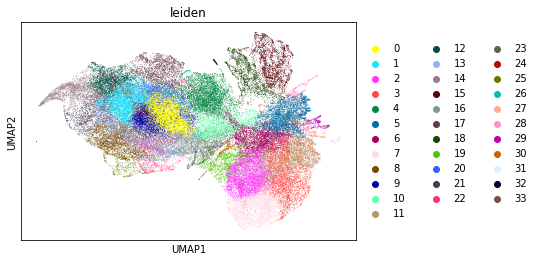

In [29]:
sc.pl.umap(adata2,color='leiden')

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


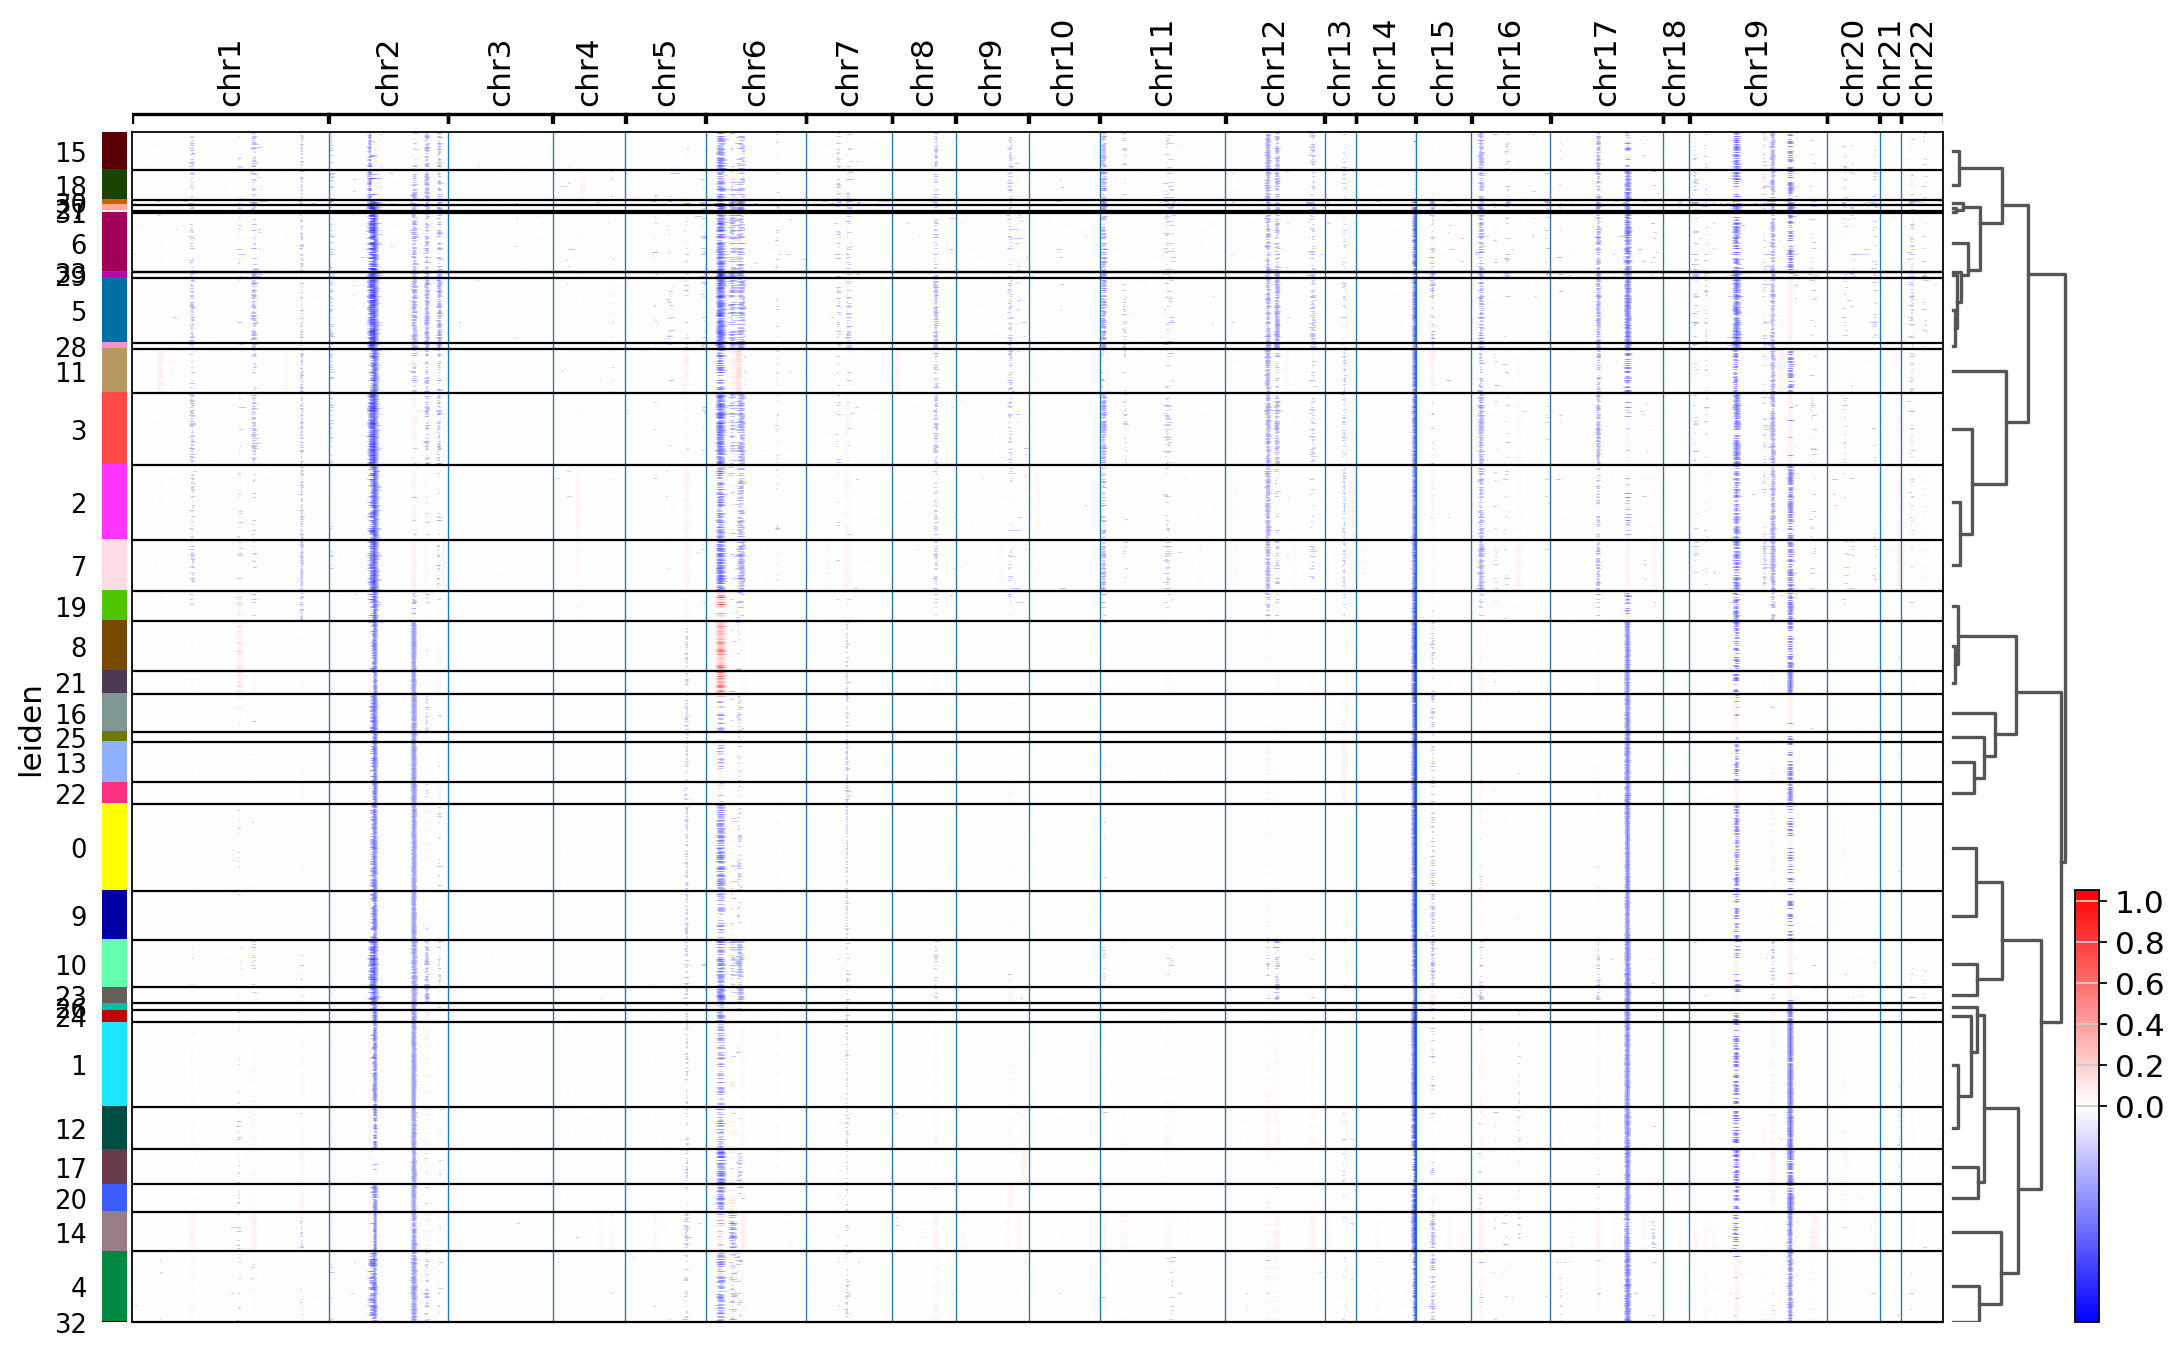

In [39]:
cnv.pl.chromosome_heatmap(adata2, groupby="leiden", dendrogram=True)

... storing 'chromosome' as categorical
/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


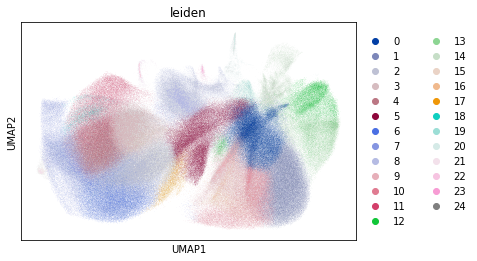

In [33]:
sc.pl.umap(adata,color='leiden')

In [ ]:
sc.pl.umap(adata,color='leiden')

In [33]:
import numpy as np
adata2.obsm['spatial']=np.array(adata2.obs.loc[:,['CenterX_global_px','CenterY_global_px']])

/home/sergio/.local/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


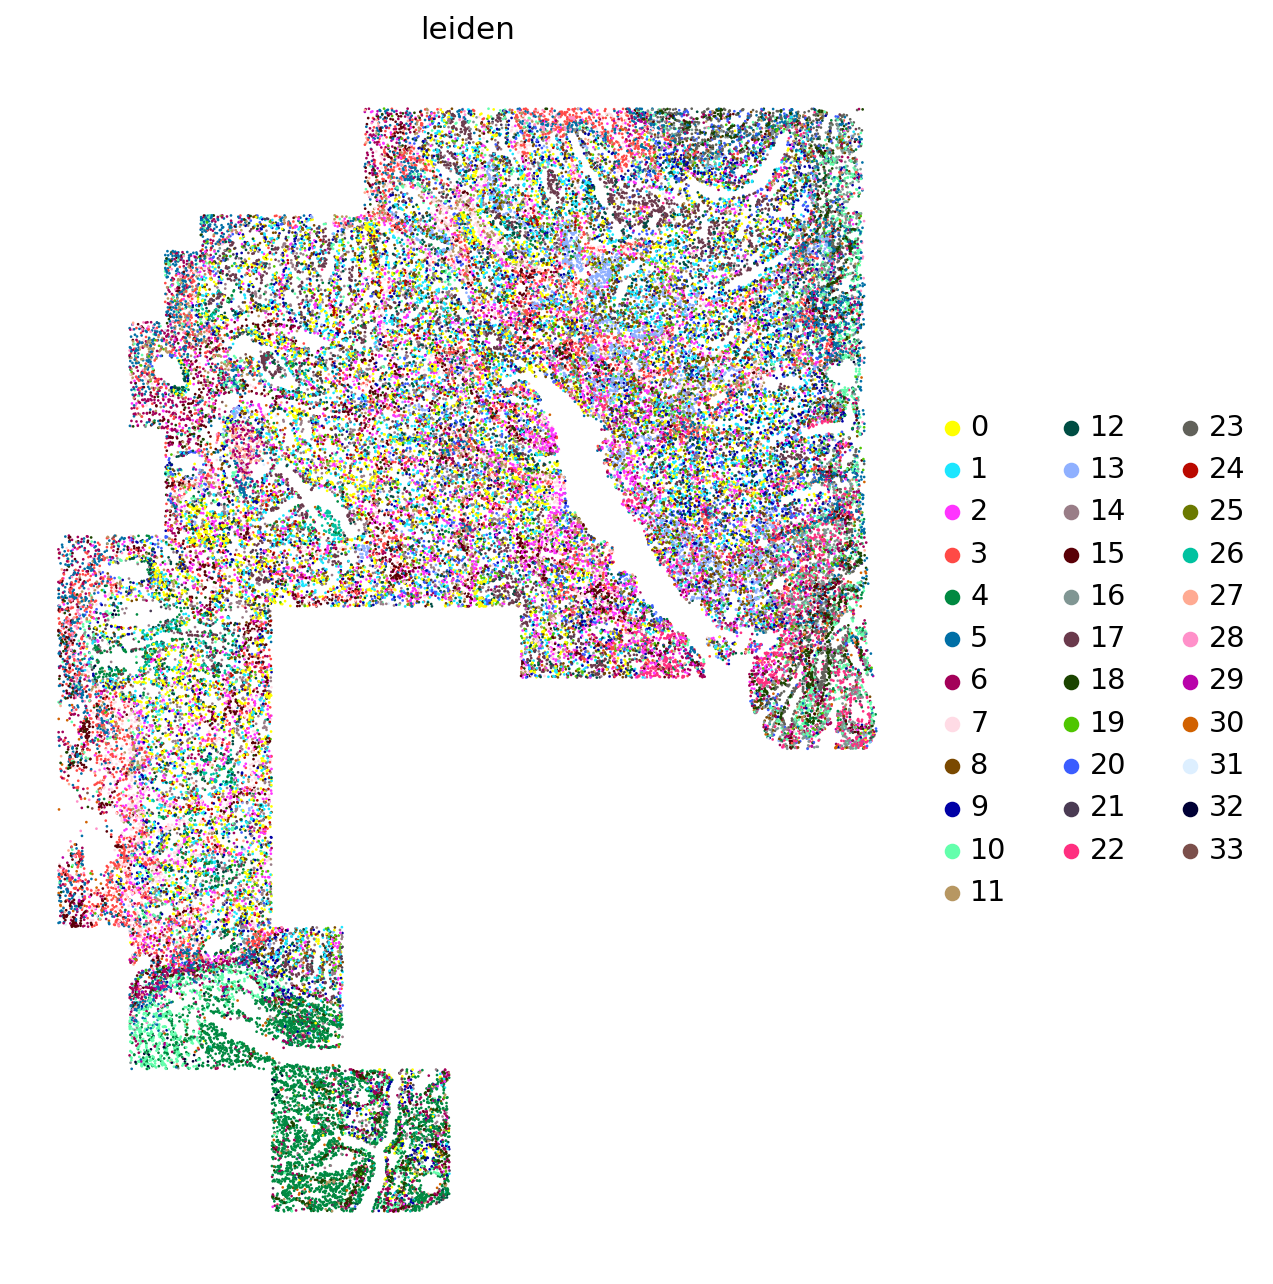

In [40]:
sc.settings.set_figure_params(figsize=(10, 10))
sc.pl.spatial(adata2,color='leiden',spot_size=320,frameon=False)

In [35]:
sc.tl.rank_genes_groups(adata2,groupby='leiden')

... storing 'chromosome' as categorical


KeyError: 'leiden'

/home/sergio/.local/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


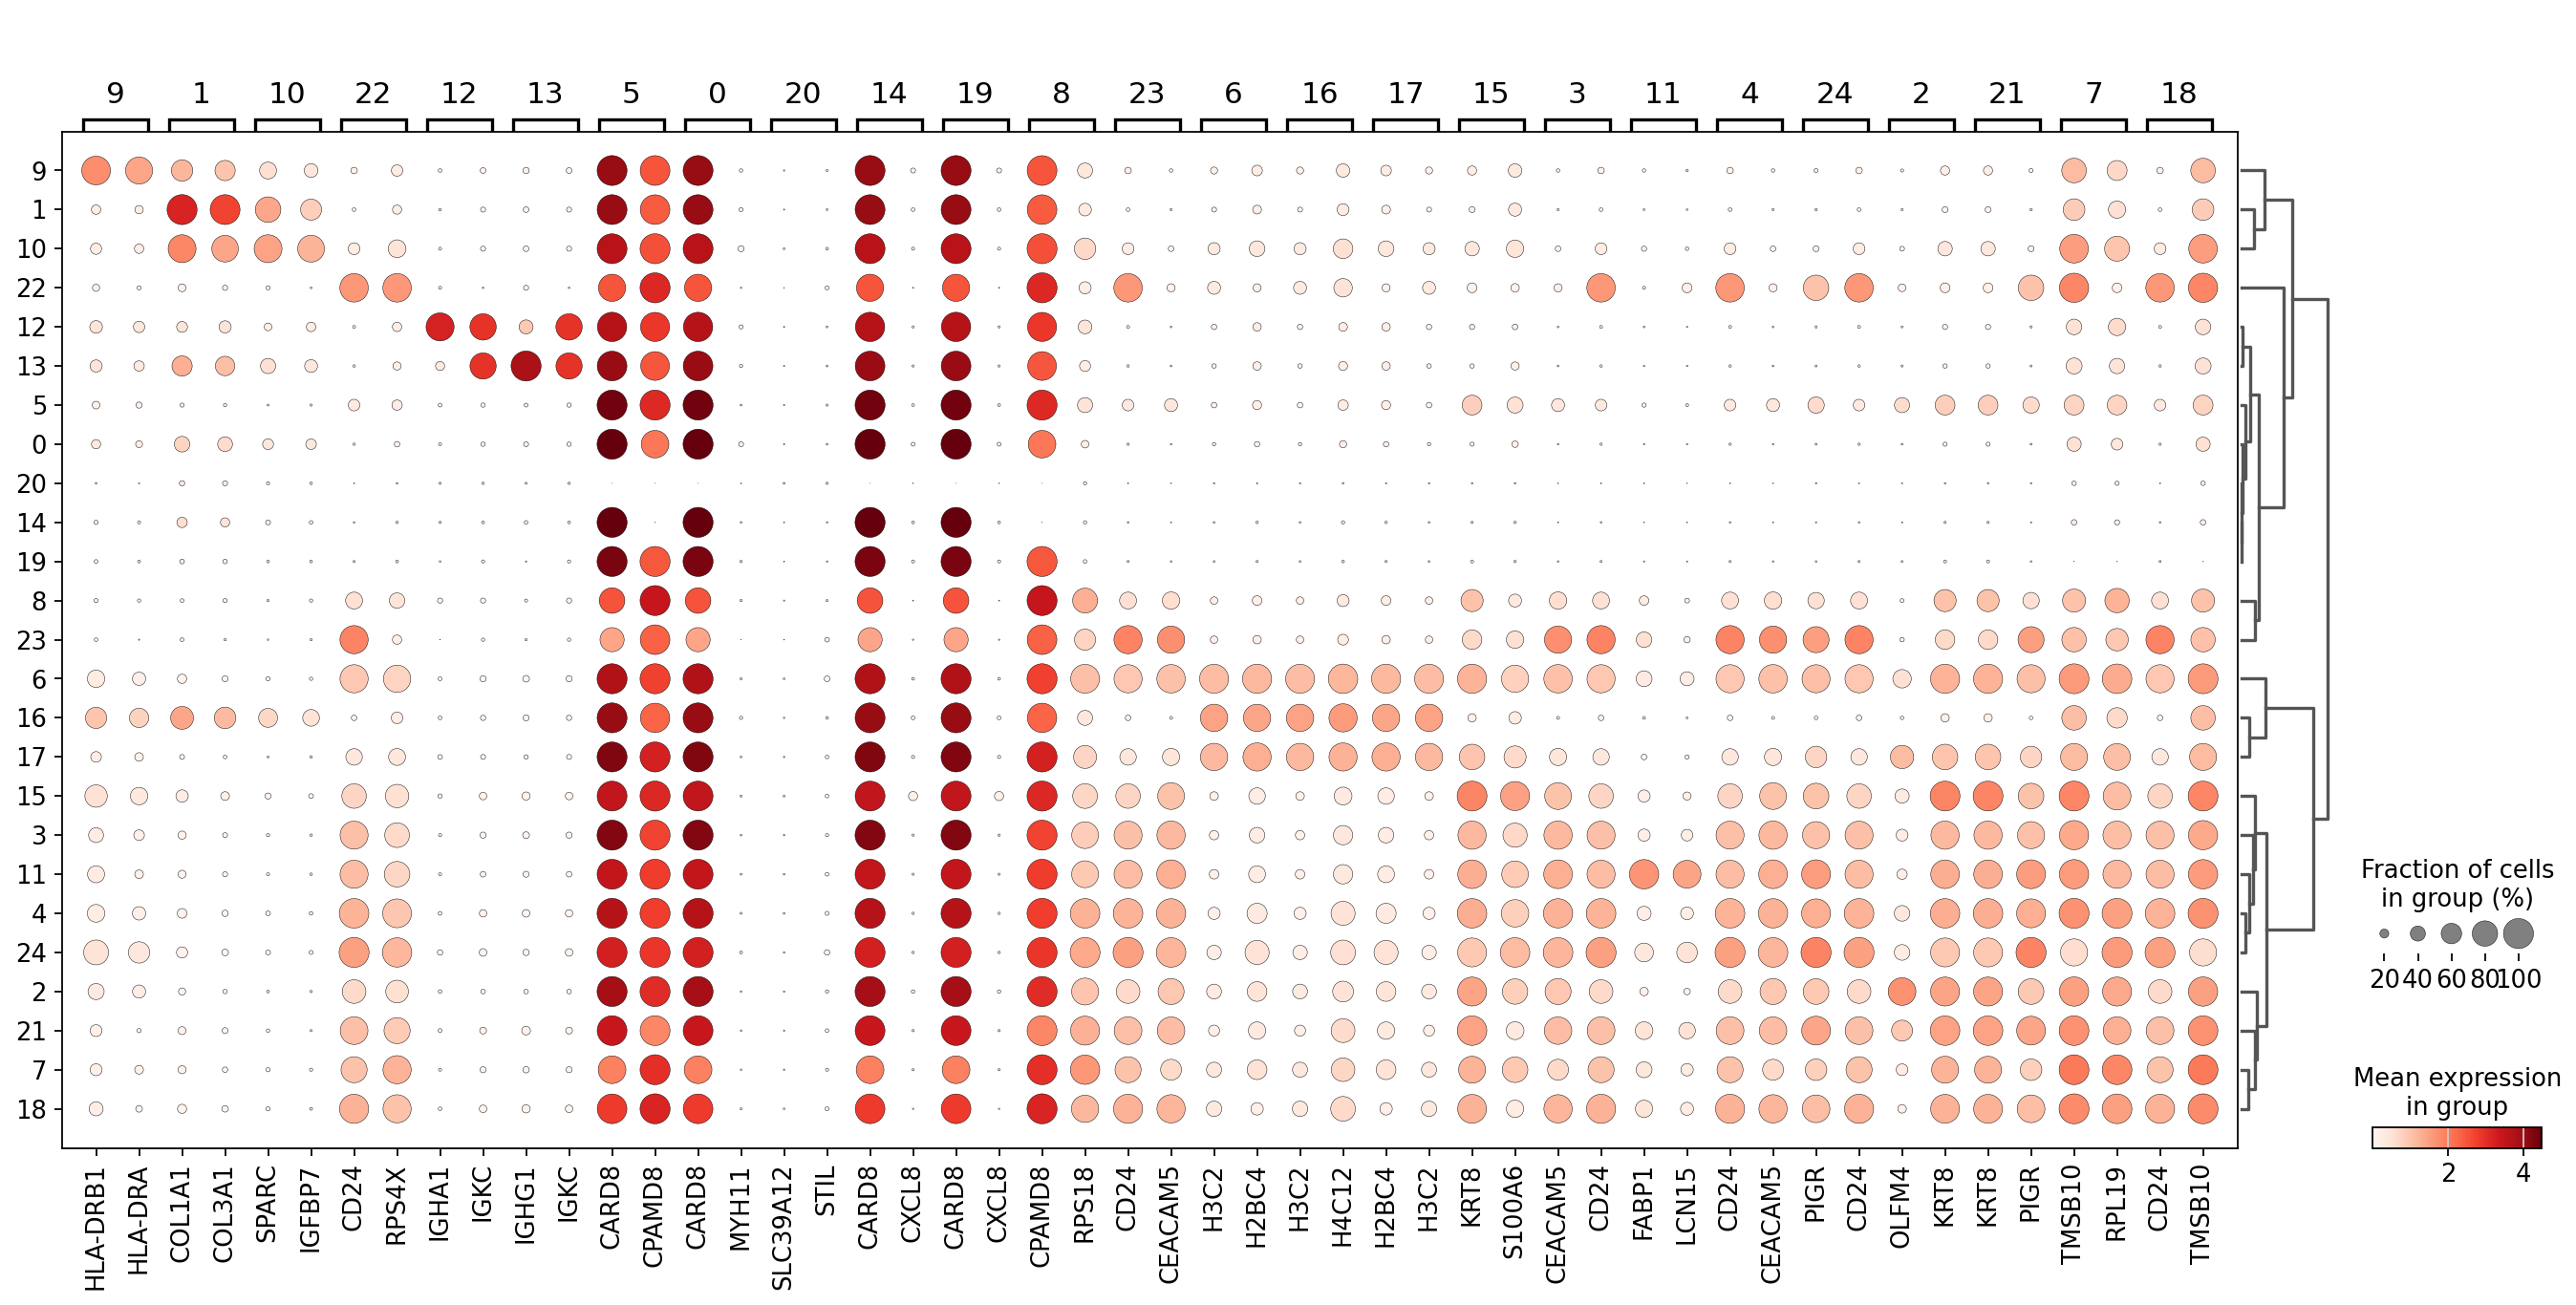

In [50]:
sc.settings.set_figure_params(figsize=(7, 7))
sc.pl.rank_genes_groups_dotplot(adata,n_genes=2)

In [48]:
adata2.X=

AnnData object with n_obs × n_vars = 74080 × 18555
    obs: 'Unnamed: 0', 'fov', 'Area', 'AspectRatio', 'CenterX_local_px', 'CenterY_local_px', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68_CK8_18', 'Max.CD68_CK8_18', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'version', 'Run_name', 'Run_Tissue_name', 'tissue', 'Panel', 'assay_type', 'slide_ID', 'CenterX_global_px', 'CenterY_global_px', 'cell_ID', 'unassignedTranscripts', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'Area.um2', 'cell', 'sid', 'n_counts', 'leiden'
    var: 'Unnamed: 0', 'start', 'end', 'width', 'names', 'gene_id', 'symbol', 'ensg', 'chromosome', 'gene_count_corr'
    uns: 'pca', 'neighbors', 'cnv', 'log1p', 'leiden', 'umap', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_cnv', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'raw', 'Ms'
    obsp: 'distances', 'connectivities'

In [49]:
cnv.tl.infercnv(adata2, reference_key="leiden", reference_cat=['2','10'], window_size=200,layer='Ms')

  0%|          | 0/15 [00:01<?, ?it/s]

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


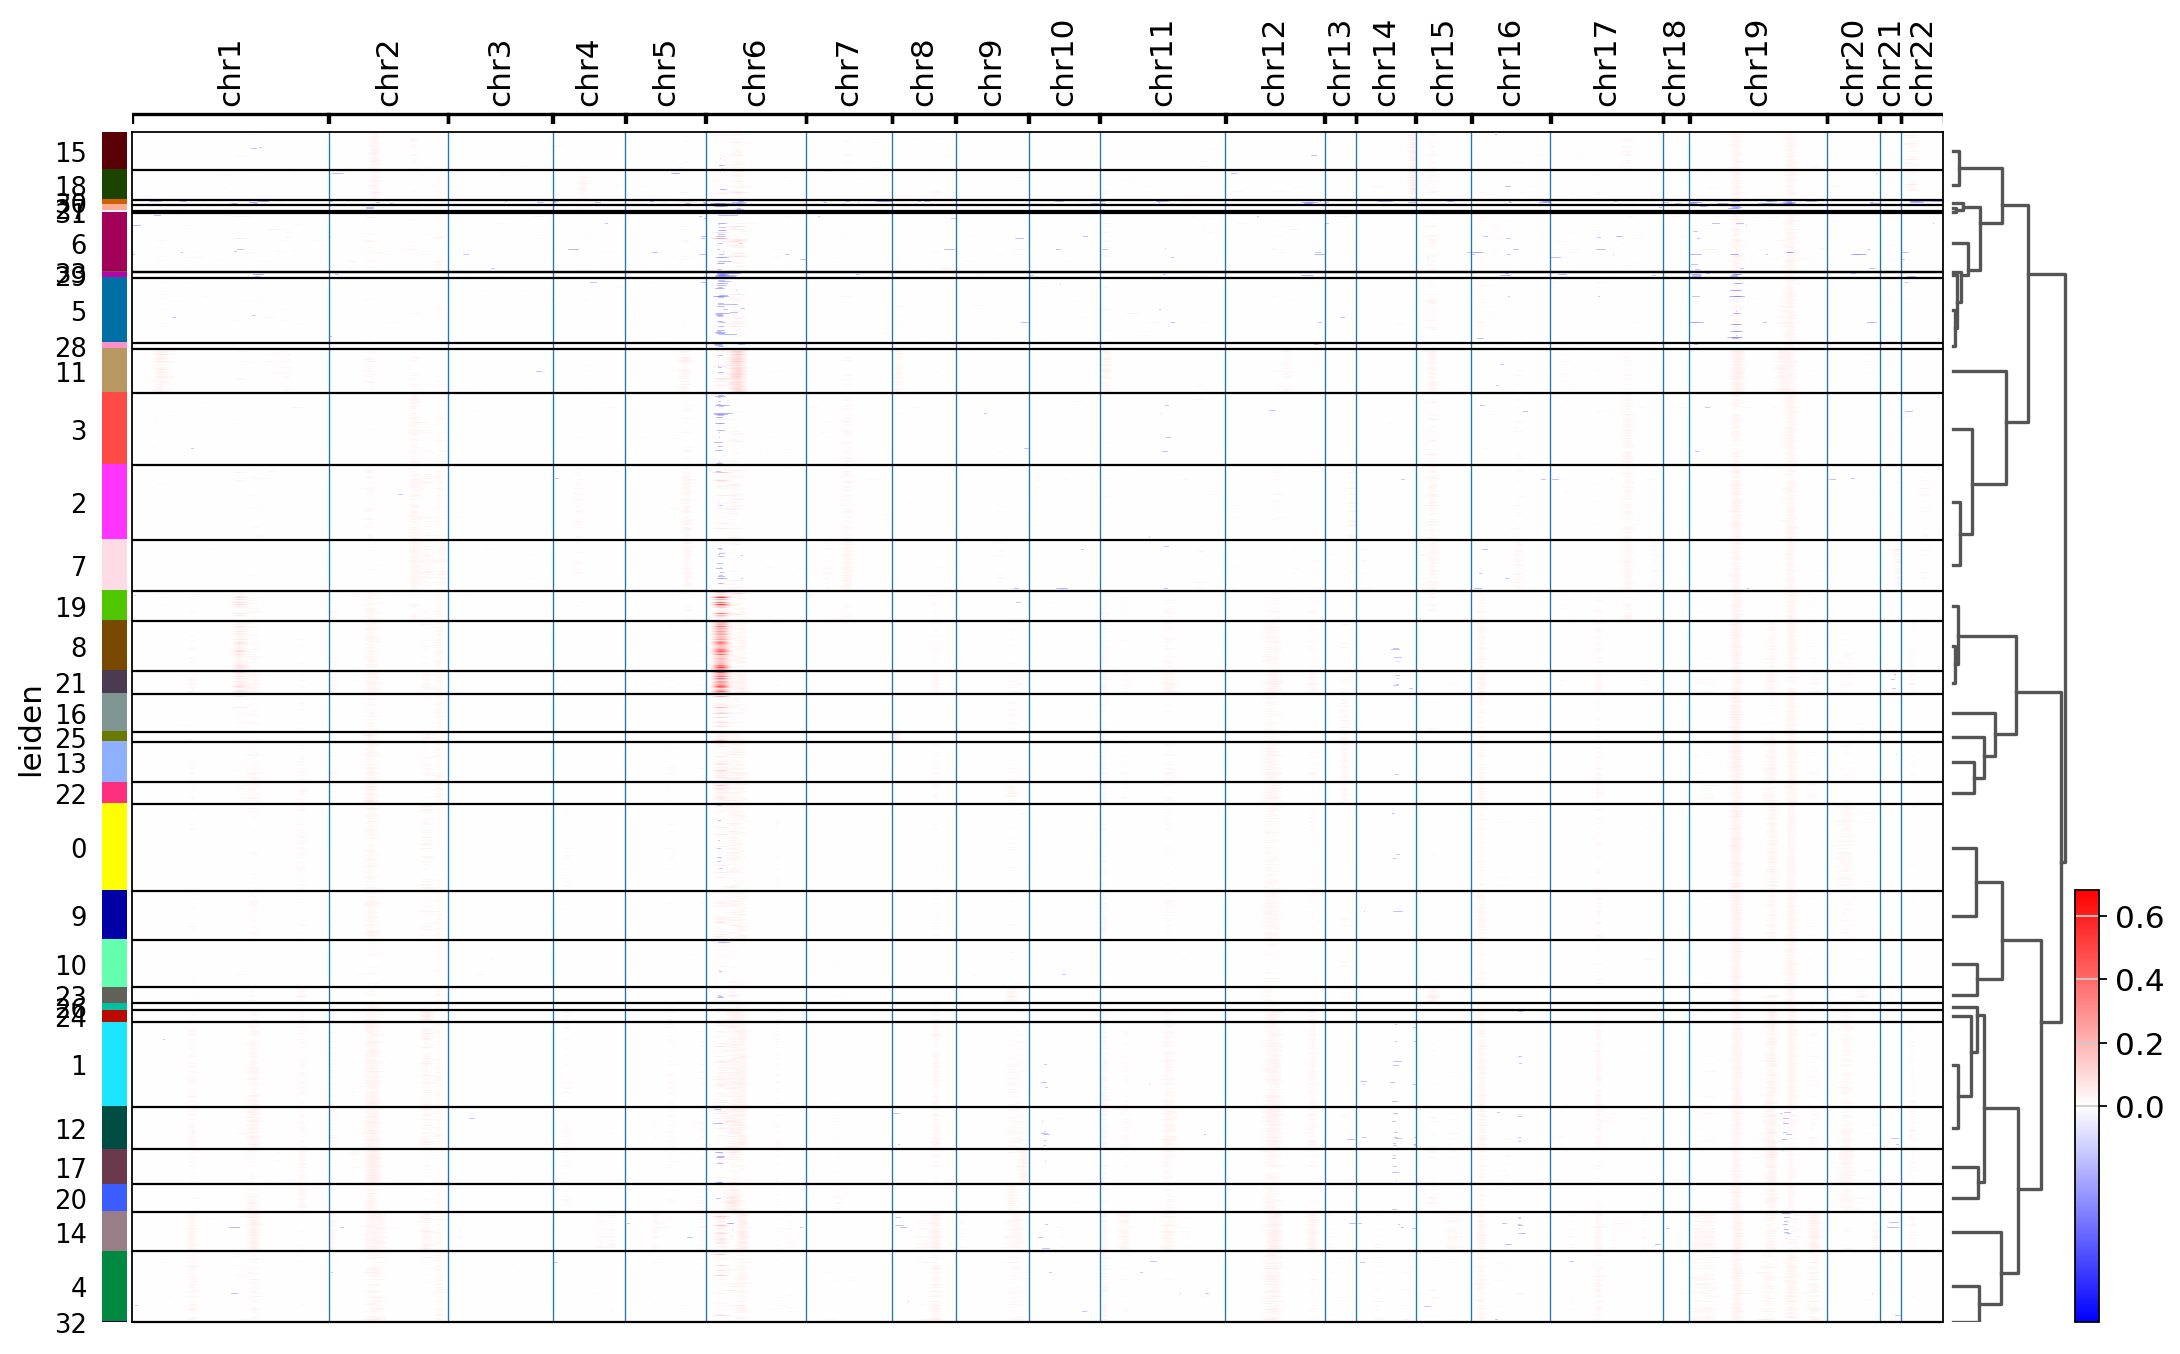

In [50]:
cnv.pl.chromosome_heatmap(adata2, groupby="leiden", dendrogram=True)

In [51]:
cnv.tl.infercnv(adata2, reference_key="leiden", reference_cat=['2','10'], window_size=200,layer='raw')

  0%|          | 0/15 [00:00<?, ?it/s]

categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


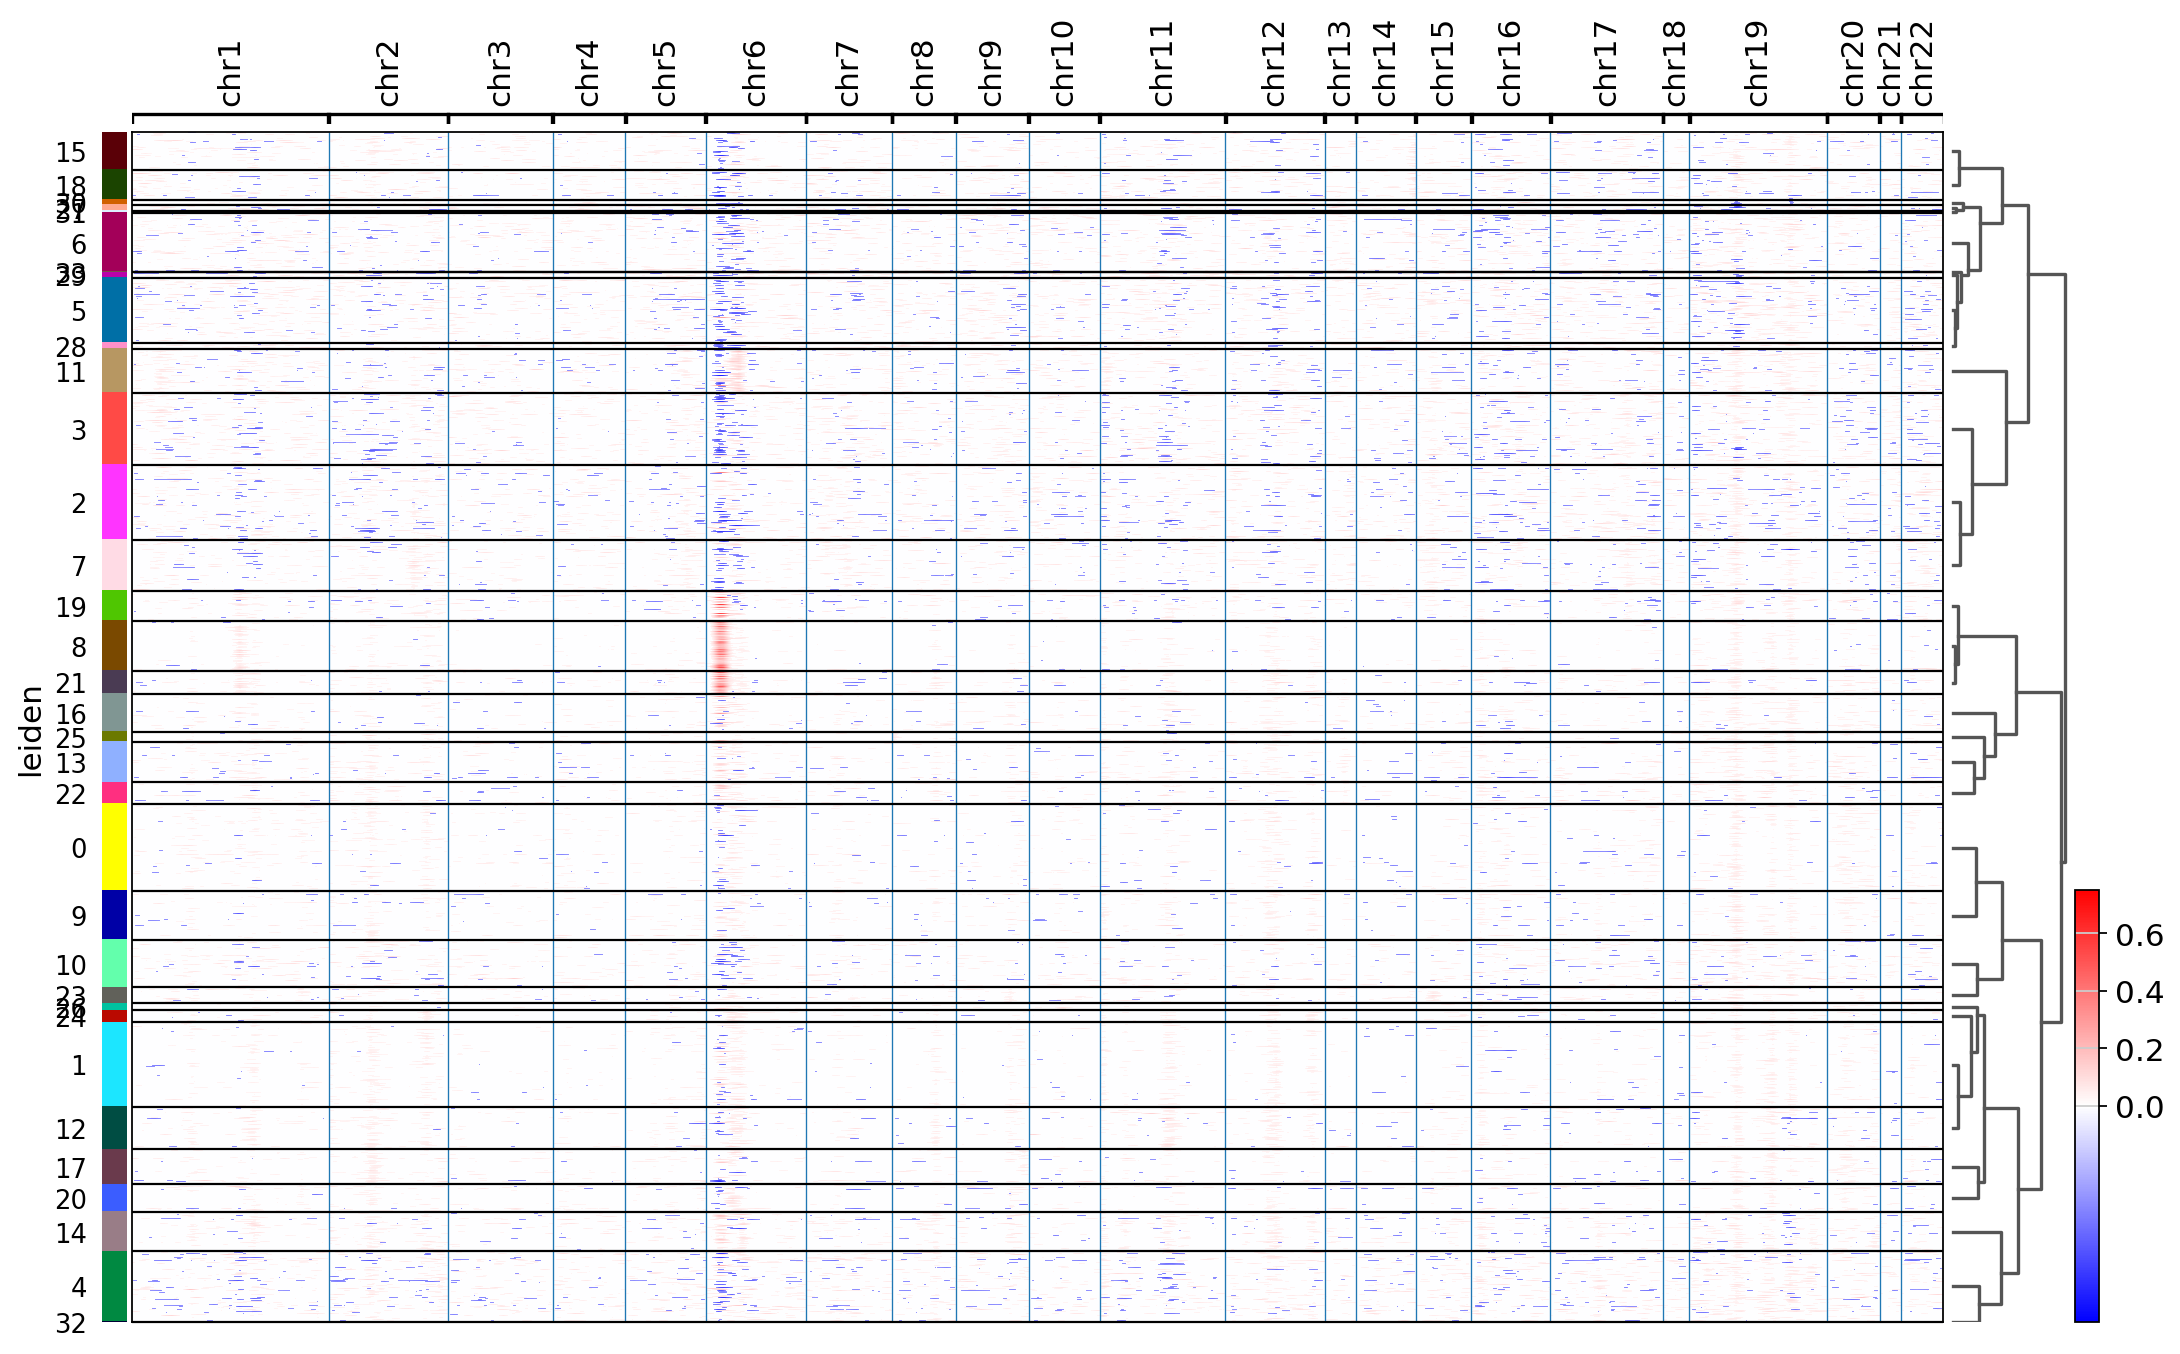

In [52]:
cnv.pl.chromosome_heatmap(adata2, groupby="leiden", dendrogram=True)

In [57]:
adata.write('/media/sergio/Meninges/CosMx-WTx/WTx-CosMx/raw-B-1970164-01-04_2/adata_1970164_processed.h5ad')

In [65]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)

In [66]:
cnv.tl.leiden(adata,resolution=0.2)

In [ ]:
sc.pl.umap(adata,color='cnv_leiden')

In [ ]:
sc.pl.spatial(adata,color='cnv_leiden')